# Over / Under with Nested Models
Last time, we explored the calibration of the individual team runs scored models.

We observed some degree of mis-calibration: over-predicting the probability of low runs scored, under-predicting the probability of high runs scored
However, these discrepancies did not seem large enough to explain the high degree of miscalibration in the overall model
- Concluded that the independence assumption must be flawed
- In this notebook, we use nested modeling to predict the total runs scored

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import structureboost as stb
import ml_insights as mli
import scipy as sp

pd.set_option('display.max_columns',1000)
pd.set_option('display.max_rows',1000)

In [2]:
# How unlikely is it that we would get 198 (or fewer) successes in 342 trials if the success probability is .7?
.7*(198+144)


239.39999999999998

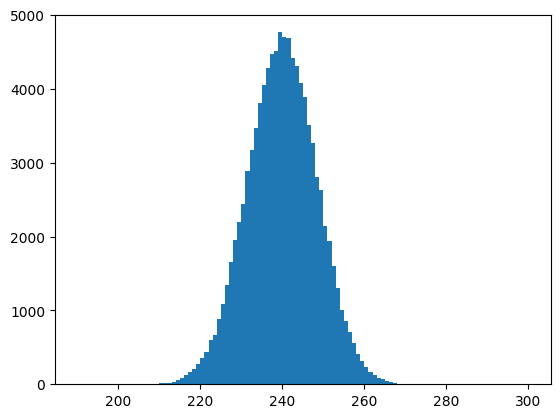

In [3]:
plt.hist(np.random.binomial(n=(198+144), p=.7, size=100000), bins=np.linspace(190,300,111));

In [5]:
df=pd.read_csv('Data/df_bp9.csv')
df_runs=pd.read_csv('Data/df_runs_bp11.csv')

/tmp/ipykernel_126033/145339343.py:1: DtypeWarning: Columns (13,14,15,19,85,87,159,198) have mixed types. Specify dtype option on import or set low_memory=False.
  df=pd.read_csv('Data/df_bp9.csv')
/tmp/ipykernel_126033/145339343.py:2: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  df_runs=pd.read_csv('Data/df_runs_bp11.csv')


In [6]:
df.over_under_line.max()

15.0

In [7]:
df_runs['runs_trunc'] = np.minimum(df_runs['runs'],16)

## Nested Modeling
- Idea: use the outputs of one model as the inputs to a second model
- Want to use the predicted distributions (and the over / under line) to predict probability of over / under (rather than relying on the independence assumption)
- Problem: If we use our previous runs scored model and apply it to the training data, the predictions will be overconfident (or otherwise weird)
- Need predicted distributions on the training set that are "credible" (i.e. predictions from a model that did not see that point in the training set)
- We will use cross-validation to get these values.
- We will create folds based on time.

In [8]:
fold_dict = {}
fold_dict[1980]=-1
for i in range(1981,2018,5):
    fold_dict[i]=0
for i in range(1982,2018,5):
    fold_dict[i]=1
for i in range(1983,2018,5):
    fold_dict[i]=2
for i in range(1984,2018,5):
    fold_dict[i]=3
for i in range(1985,2018,5):
    fold_dict[i]=4
fold_dict[2018] = 5 # validation set
for i in range(2018,2023):
    fold_dict[i]=6 # test set
df_runs['foldnum1'] = df_runs.season.apply(lambda x: fold_dict[x])


In [9]:
pd.crosstab(df_runs.season, df_runs.foldnum1)

foldnum1,-1,0,1,2,3,4,6
season,,,,,,,
1980,4210,0,0,0,0,0,0
1981,0,2788,0,0,0,0,0
1982,0,0,4212,0,0,0,0
1983,0,0,0,4216,0,0,0
1984,0,0,0,0,4210,0,0
1985,0,0,0,0,0,4206,0
1986,0,4204,0,0,0,0,0
1987,0,0,4208,0,0,0,0
1988,0,0,0,4200,0,0,0


In [10]:
df_runs.shape

(192500, 159)

In [11]:
df_runs.iloc[:5,:]

,season,date,dblheader_code,date_dblhead,team_h,team_v,league_h,league_v,over_under_line,over_under_result,ballpark_id,day_night,runs,BATAVG_30,OBP_30,SLG_30,OBS_30,ERR_30,SB_30,CS_30,BATAVG_162,OBP_162,SLG_162,OBS_162,ERR_162,SB_162,CS_162,lineup8_BATAVG_30,lineup9_BATAVG_30,lineup8_BATAVG_30_w,lineup9_BATAVG_30_w,lineup8_OBP_30,lineup9_OBP_30,lineup8_OBP_30_w,lineup9_OBP_30_w,lineup8_SLG_30,lineup9_SLG_30,lineup8_SLG_30_w,lineup9_SLG_30_w,lineup8_OBS_30,lineup9_OBS_30,lineup8_OBS_30_w,lineup9_OBS_30_w,lineup8_SLGmod_30,lineup9_SLGmod_30,lineup8_SLGmod_30_w,lineup9_SLGmod_30_w,lineup8_SObat_perc_30,lineup9_SObat_perc_30,lineup8_SObat_perc_30_w,lineup9_SObat_perc_30_w,lineup8_BATAVG_75,lineup9_BATAVG_75,lineup8_BATAVG_75_w,lineup9_BATAVG_75_w,lineup8_OBP_75,lineup9_OBP_75,lineup8_OBP_75_w,lineup9_OBP_75_w,lineup8_SLG_75,lineup9_SLG_75,lineup8_SLG_75_w,lineup9_SLG_75_w,lineup8_OBS_75,lineup9_OBS_75,lineup8_OBS_75_w,lineup9_OBS_75_w,lineup8_SLGmod_75,lineup9_SLGmod_75,lineup8_SLGmod_75_w,lineup9_SLGmod_75_w,lineup8_SObat_perc_75,lineup9_SObat_perc_75,lineup8_SObat_perc_75_w,lineup9_SObat_perc_75_w,lineup8_BATAVG_162,lineup9_BATAVG_162,lineup8_BATAVG_162_w,lineup9_BATAVG_162_w,lineup8_OBP_162,lineup9_OBP_162,lineup8_OBP_162_w,lineup9_OBP_162_w,lineup8_SLG_162,lineup9_SLG_162,lineup8_SLG_162_w,lineup9_SLG_162_w,lineup8_OBS_162,lineup9_OBS_162,lineup8_OBS_162_w,lineup9_OBS_162_w,lineup8_SLGmod_162,lineup9_SLGmod_162,lineup8_SLGmod_162_w,lineup9_SLGmod_162_w,lineup8_SObat_perc_162,lineup9_SObat_perc_162,lineup8_SObat_perc_162_w,lineup9_SObat_perc_162_w,lineup8_BATAVG_350,lineup9_BATAVG_350,lineup8_BATAVG_350_w,lineup9_BATAVG_350_w,lineup8_OBP_350,lineup9_OBP_350,lineup8_OBP_350_w,lineup9_OBP_350_w,lineup8_SLG_350,lineup9_SLG_350,lineup8_SLG_350_w,lineup9_SLG_350_w,lineup8_OBS_350,lineup9_OBS_350,lineup8_OBS_350_w,lineup9_OBS_350_w,lineup8_SLGmod_350,lineup9_SLGmod_350,lineup8_SLGmod_350_w,lineup9_SLGmod_350_w,lineup8_SObat_perc_350,lineup9_SObat_perc_350,lineup8_SObat_perc_350_w,lineup9_SObat_perc_350_w,Strt_ERA_10,Strt_WHIP_10,Strt_SO_perc_10,Strt_H_BB_perc_10,Strt_TB_BB_perc_10,Strt_FIP_10,Strt_FIP_perc_10,Strt_ERA_35,Strt_WHIP_35,Strt_SO_perc_35,Strt_H_BB_perc_35,Strt_TB_BB_perc_35,Strt_FIP_35,Strt_FIP_perc_35,Strt_ERA_75,Strt_WHIP_75,Strt_SO_perc_75,Strt_H_BB_perc_75,Strt_TB_BB_perc_75,Strt_FIP_75,Strt_FIP_perc_75,Bpen_WHIP_10,Bpen_SO_perc_10,Bpen_H_BB_perc_10,Bpen_TB_BB_perc_10,Bpen_WHIP_35,Bpen_SO_perc_35,Bpen_H_BB_perc_35,Bpen_TB_BB_perc_35,Bpen_WHIP_75,Bpen_SO_perc_75,Bpen_H_BB_perc_75,Bpen_TB_BB_perc_75,home_hitting,runs_trunc,foldnum1
0,1980,19800409,0,198004090,SEA,TOR,AL,AL,0.0,NaN,SEA02,N,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.258957,0.244999,0.261081,0.248690,0.316389,0.299753,0.318195,0.303498,0.391599,0.366607,0.393452,0.371455,0.707988,0.666360,0.711647,0.674953,0.302610,0.283802,0.301660,0.285333,0.103902,0.099765,0.103370,0.099810,0.247605,0.241513,0.247225,0.241943,0.302829,0.293223,0.301952,0.293652,0.357380,0.344445,0.356761,0.345529,0.660209,0.637667,0.658713,0.639181,0.277352,0.272526,0.275707,0.271654,0.101148,0.107454,0.100206,0.105801,0.236959,0.232164,0.235594,0.231540,0.293375,0.284567,0.291567,0.284053,0.341385,0.330441,0.339080,0.329750,0.634760,0.615009,0.630646,0.613803,0.271778,0.267889,0.269267,0.266116,0.101146,0.108100,0.099922,0.106111,0.207199,0.203860,0.206608,0.203750,0.259931,0.254701,0.258950,0.254479,0.296881,0.288656,0.295494,0.288449,0.556812,0.543357,0.554444,0.542928,0.243524,0.242021,0.241553,0.240432,0.092185,0.098451,0.091244,0.096804,5.692771,1.572289,0.104418,0.349398,0.502008,5.186747,1.152610,3.857143,1.357945,0.115165,0.321551,0.434436,4.040128,0.956670,4.644315,1.460641,0.098187,0.336354,0.459215,4.723032,1.087613,1.5,0.2,0.37,0.45,1.5,0.2,0.37,0.45,1.5,0.2,0.37,0.45,1,8,-1
1,1980,19800409,0,198004090,CIN,ATL,NL,NL,0.0,NaN,CIN08,D,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.291169,0.266224,0.291499,0.269692,0.358840,0.326376,0.359266,0.3308

In [12]:
df_runs.iloc[96248:96253,:]

,season,date,dblheader_code,date_dblhead,team_h,team_v,league_h,league_v,over_under_line,over_under_result,ballpark_id,day_night,runs,BATAVG_30,OBP_30,SLG_30,OBS_30,ERR_30,SB_30,CS_30,BATAVG_162,OBP_162,SLG_162,OBS_162,ERR_162,SB_162,CS_162,lineup8_BATAVG_30,lineup9_BATAVG_30,lineup8_BATAVG_30_w,lineup9_BATAVG_30_w,lineup8_OBP_30,lineup9_OBP_30,lineup8_OBP_30_w,lineup9_OBP_30_w,lineup8_SLG_30,lineup9_SLG_30,lineup8_SLG_30_w,lineup9_SLG_30_w,lineup8_OBS_30,lineup9_OBS_30,lineup8_OBS_30_w,lineup9_OBS_30_w,lineup8_SLGmod_30,lineup9_SLGmod_30,lineup8_SLGmod_30_w,lineup9_SLGmod_30_w,lineup8_SObat_perc_30,lineup9_SObat_perc_30,lineup8_SObat_perc_30_w,lineup9_SObat_perc_30_w,lineup8_BATAVG_75,lineup9_BATAVG_75,lineup8_BATAVG_75_w,lineup9_BATAVG_75_w,lineup8_OBP_75,lineup9_OBP_75,lineup8_OBP_75_w,lineup9_OBP_75_w,lineup8_SLG_75,lineup9_SLG_75,lineup8_SLG_75_w,lineup9_SLG_75_w,lineup8_OBS_75,lineup9_OBS_75,lineup8_OBS_75_w,lineup9_OBS_75_w,lineup8_SLGmod_75,lineup9_SLGmod_75,lineup8_SLGmod_75_w,lineup9_SLGmod_75_w,lineup8_SObat_perc_75,lineup9_SObat_perc_75,lineup8_SObat_perc_75_w,lineup9_SObat_perc_75_w,lineup8_BATAVG_162,lineup9_BATAVG_162,lineup8_BATAVG_162_w,lineup9_BATAVG_162_w,lineup8_OBP_162,lineup9_OBP_162,lineup8_OBP_162_w,lineup9_OBP_162_w,lineup8_SLG_162,lineup9_SLG_162,lineup8_SLG_162_w,lineup9_SLG_162_w,lineup8_OBS_162,lineup9_OBS_162,lineup8_OBS_162_w,lineup9_OBS_162_w,lineup8_SLGmod_162,lineup9_SLGmod_162,lineup8_SLGmod_162_w,lineup9_SLGmod_162_w,lineup8_SObat_perc_162,lineup9_SObat_perc_162,lineup8_SObat_perc_162_w,lineup9_SObat_perc_162_w,lineup8_BATAVG_350,lineup9_BATAVG_350,lineup8_BATAVG_350_w,lineup9_BATAVG_350_w,lineup8_OBP_350,lineup9_OBP_350,lineup8_OBP_350_w,lineup9_OBP_350_w,lineup8_SLG_350,lineup9_SLG_350,lineup8_SLG_350_w,lineup9_SLG_350_w,lineup8_OBS_350,lineup9_OBS_350,lineup8_OBS_350_w,lineup9_OBS_350_w,lineup8_SLGmod_350,lineup9_SLGmod_350,lineup8_SLGmod_350_w,lineup9_SLGmod_350_w,lineup8_SObat_perc_350,lineup9_SObat_perc_350,lineup8_SObat_perc_350_w,lineup9_SObat_perc_350_w,Strt_ERA_10,Strt_WHIP_10,Strt_SO_perc_10,Strt_H_BB_perc_10,Strt_TB_BB_perc_10,Strt_FIP_10,Strt_FIP_perc_10,Strt_ERA_35,Strt_WHIP_35,Strt_SO_perc_35,Strt_H_BB_perc_35,Strt_TB_BB_perc_35,Strt_FIP_35,Strt_FIP_perc_35,Strt_ERA_75,Strt_WHIP_75,Strt_SO_perc_75,Strt_H_BB_perc_75,Strt_TB_BB_perc_75,Strt_FIP_75,Strt_FIP_perc_75,Bpen_WHIP_10,Bpen_SO_perc_10,Bpen_H_BB_perc_10,Bpen_TB_BB_perc_10,Bpen_WHIP_35,Bpen_SO_perc_35,Bpen_H_BB_perc_35,Bpen_TB_BB_perc_35,Bpen_WHIP_75,Bpen_SO_perc_75,Bpen_H_BB_perc_75,Bpen_TB_BB_perc_75,home_hitting,runs_trunc,foldnum1
96248,2022,20221005,0,202210050,SEA,DET,AL,AL,7.5,O,SEA03,D,5,0.223577,0.309846,0.398374,0.70822,21.0,15.0,6.0,0.229868,0.306597,0.388135,0.694732,70.0,84.0,27.0,0.218097,0.214395,0.221064,0.217545,0.295403,0.302467,0.297106,0.303107,0.380935,0.368802,0.387313,0.376103,0.676338,0.671269,0.684419,0.679210,0.504862,0.498149,0.504840,0.498982,0.259738,0.248922,0.257720,0.248474,0.223164,0.223347,0.225154,0.225121,0.295949,0.300349,0.297163,0.300886,0.395174,0.383135,0.399872,0.388906,0.691123,0.683484,0.697035,0.689792,0.505733,0.483501,0.505235,0.485876,0.256937,0.240570,0.254626,0.240563,0.223196,0.226504,0.225459,0.228127,0.305636,0.310467,0.307169,0.311237,0.386906,0.382777,0.390649,0.386682,0.692541,0.693243,0.697818,0.697919,0.491441,0.474805,0.490974,0.476497,0.239131,0.226861,0.237873,0.227284,0.209450,0.214781,0.210889,0.215403,0.286582,0.292305,0.287914,0.292781,0.356449,0.355940,0.359015,0.358321,0.643031,0.648244,0.646929,0.651102,0.437698,0.427686,0.438097,0.429318,0.207395,0.201550,0.206821,0.201774,5.264151,1.377358,0.141593,0.323009,0.530973,5.377358,1.261062,4.082927,1.273171,0.157343,0.304196,0.465035,4.404878,1.052448,4.174815,1.302222,0.169118,0.306723,0.473739,4.497813,1.063034,1.38843,0.226190,0.333333,0.416667,1.350746,0.243816,0.319788,0.445230,1.342105,0.233191,0.318298,0.429787,1,5,6
96249,2022,20221005,0,202210050,TEX,NYA,AL,AL,8.0,U,ARL03,D,4,0.211753,0.262559,0.36778

In [13]:
df_train = df_runs[(df_runs.season>1980) & (df_runs.season<=2017)]
df_valid = df_runs[(df_runs.season>=2018) & (df_runs.season<=2018)]
df_test = df_runs[df_runs.season>=2019]

df_test_game = df[df.season>=2019]


In [14]:
df_train.shape, df_valid.shape, df_test.shape

((167076, 159), (4856, 159), (16358, 159))

In [15]:
df_train.shape[0] /2,  df_valid.shape[0]/2, df_test.shape[0]/2

(83538.0, 2428.0, 8179.0)

In [16]:
df_train.iloc[:5,:]

,season,date,dblheader_code,date_dblhead,team_h,team_v,league_h,league_v,over_under_line,over_under_result,ballpark_id,day_night,runs,BATAVG_30,OBP_30,SLG_30,OBS_30,ERR_30,SB_30,CS_30,BATAVG_162,OBP_162,SLG_162,OBS_162,ERR_162,SB_162,CS_162,lineup8_BATAVG_30,lineup9_BATAVG_30,lineup8_BATAVG_30_w,lineup9_BATAVG_30_w,lineup8_OBP_30,lineup9_OBP_30,lineup8_OBP_30_w,lineup9_OBP_30_w,lineup8_SLG_30,lineup9_SLG_30,lineup8_SLG_30_w,lineup9_SLG_30_w,lineup8_OBS_30,lineup9_OBS_30,lineup8_OBS_30_w,lineup9_OBS_30_w,lineup8_SLGmod_30,lineup9_SLGmod_30,lineup8_SLGmod_30_w,lineup9_SLGmod_30_w,lineup8_SObat_perc_30,lineup9_SObat_perc_30,lineup8_SObat_perc_30_w,lineup9_SObat_perc_30_w,lineup8_BATAVG_75,lineup9_BATAVG_75,lineup8_BATAVG_75_w,lineup9_BATAVG_75_w,lineup8_OBP_75,lineup9_OBP_75,lineup8_OBP_75_w,lineup9_OBP_75_w,lineup8_SLG_75,lineup9_SLG_75,lineup8_SLG_75_w,lineup9_SLG_75_w,lineup8_OBS_75,lineup9_OBS_75,lineup8_OBS_75_w,lineup9_OBS_75_w,lineup8_SLGmod_75,lineup9_SLGmod_75,lineup8_SLGmod_75_w,lineup9_SLGmod_75_w,lineup8_SObat_perc_75,lineup9_SObat_perc_75,lineup8_SObat_perc_75_w,lineup9_SObat_perc_75_w,lineup8_BATAVG_162,lineup9_BATAVG_162,lineup8_BATAVG_162_w,lineup9_BATAVG_162_w,lineup8_OBP_162,lineup9_OBP_162,lineup8_OBP_162_w,lineup9_OBP_162_w,lineup8_SLG_162,lineup9_SLG_162,lineup8_SLG_162_w,lineup9_SLG_162_w,lineup8_OBS_162,lineup9_OBS_162,lineup8_OBS_162_w,lineup9_OBS_162_w,lineup8_SLGmod_162,lineup9_SLGmod_162,lineup8_SLGmod_162_w,lineup9_SLGmod_162_w,lineup8_SObat_perc_162,lineup9_SObat_perc_162,lineup8_SObat_perc_162_w,lineup9_SObat_perc_162_w,lineup8_BATAVG_350,lineup9_BATAVG_350,lineup8_BATAVG_350_w,lineup9_BATAVG_350_w,lineup8_OBP_350,lineup9_OBP_350,lineup8_OBP_350_w,lineup9_OBP_350_w,lineup8_SLG_350,lineup9_SLG_350,lineup8_SLG_350_w,lineup9_SLG_350_w,lineup8_OBS_350,lineup9_OBS_350,lineup8_OBS_350_w,lineup9_OBS_350_w,lineup8_SLGmod_350,lineup9_SLGmod_350,lineup8_SLGmod_350_w,lineup9_SLGmod_350_w,lineup8_SObat_perc_350,lineup9_SObat_perc_350,lineup8_SObat_perc_350_w,lineup9_SObat_perc_350_w,Strt_ERA_10,Strt_WHIP_10,Strt_SO_perc_10,Strt_H_BB_perc_10,Strt_TB_BB_perc_10,Strt_FIP_10,Strt_FIP_perc_10,Strt_ERA_35,Strt_WHIP_35,Strt_SO_perc_35,Strt_H_BB_perc_35,Strt_TB_BB_perc_35,Strt_FIP_35,Strt_FIP_perc_35,Strt_ERA_75,Strt_WHIP_75,Strt_SO_perc_75,Strt_H_BB_perc_75,Strt_TB_BB_perc_75,Strt_FIP_75,Strt_FIP_perc_75,Bpen_WHIP_10,Bpen_SO_perc_10,Bpen_H_BB_perc_10,Bpen_TB_BB_perc_10,Bpen_WHIP_35,Bpen_SO_perc_35,Bpen_H_BB_perc_35,Bpen_TB_BB_perc_35,Bpen_WHIP_75,Bpen_SO_perc_75,Bpen_H_BB_perc_75,Bpen_TB_BB_perc_75,home_hitting,runs_trunc,foldnum1
2105,1981,19810408,0,198104080,CIN,PHI,NL,NL,0.0,NaN,CIN08,D,3,0.260274,0.317690,0.360078,0.677768,23.0,26.0,13.0,0.261900,0.327182,0.385373,0.712555,106.0,156.0,43.0,0.261491,0.245399,0.262936,0.248749,0.325573,0.315040,0.326352,0.317081,0.387758,0.363193,0.390081,0.368411,0.713332,0.678232,0.716433,0.685492,0.317936,0.339020,0.318260,0.336634,0.116678,0.141321,0.116880,0.138372,0.271826,0.256997,0.273149,0.260076,0.341794,0.324855,0.342767,0.327886,0.407049,0.385581,0.408312,0.389449,0.748842,0.710436,0.751079,0.717335,0.347727,0.363660,0.347562,0.361487,0.130207,0.155845,0.130373,0.152737,0.274354,0.259524,0.275138,0.262116,0.345153,0.329310,0.345806,0.331913,0.417573,0.393889,0.417920,0.397212,0.762725,0.723199,0.763726,0.729124,0.355185,0.368712,0.354974,0.366802,0.129753,0.153798,0.129913,0.150887,0.258644,0.246661,0.261260,0.250546,0.327018,0.314656,0.329858,0.318790,0.396584,0.376554,0.399446,0.381683,0.723602,0.691210,0.729304,0.700473,0.339735,0.354625,0.341308,0.354154,0.123324,0.147039,0.124119,0.144744,2.678571,1.154762,0.218659,0.282799,0.408163,2.607143,0.638484,2.284863,1.097735,0.238516,0.271201,0.366608,2.013111,0.497350,2.884413,1.122592,0.220595,0.276174,0.389918,2.507881,0.616975,1.110000,0.195122,0.300813,0.414634,1.203947,0.145780,0.312020,0.401535,1.250404,0.153359,0.326996,0.422053,1,3,0
2106,1981,19810409,0,198104090,DET,TOR,AL,AL,0.0,NaN,DET04,D,6,0.260077,0.345501,

In [17]:
df_train.iloc[83537:83537+5,:]

,season,date,dblheader_code,date_dblhead,team_h,team_v,league_h,league_v,over_under_line,over_under_result,ballpark_id,day_night,runs,BATAVG_30,OBP_30,SLG_30,OBS_30,ERR_30,SB_30,CS_30,BATAVG_162,OBP_162,SLG_162,OBS_162,ERR_162,SB_162,CS_162,lineup8_BATAVG_30,lineup9_BATAVG_30,lineup8_BATAVG_30_w,lineup9_BATAVG_30_w,lineup8_OBP_30,lineup9_OBP_30,lineup8_OBP_30_w,lineup9_OBP_30_w,lineup8_SLG_30,lineup9_SLG_30,lineup8_SLG_30_w,lineup9_SLG_30_w,lineup8_OBS_30,lineup9_OBS_30,lineup8_OBS_30_w,lineup9_OBS_30_w,lineup8_SLGmod_30,lineup9_SLGmod_30,lineup8_SLGmod_30_w,lineup9_SLGmod_30_w,lineup8_SObat_perc_30,lineup9_SObat_perc_30,lineup8_SObat_perc_30_w,lineup9_SObat_perc_30_w,lineup8_BATAVG_75,lineup9_BATAVG_75,lineup8_BATAVG_75_w,lineup9_BATAVG_75_w,lineup8_OBP_75,lineup9_OBP_75,lineup8_OBP_75_w,lineup9_OBP_75_w,lineup8_SLG_75,lineup9_SLG_75,lineup8_SLG_75_w,lineup9_SLG_75_w,lineup8_OBS_75,lineup9_OBS_75,lineup8_OBS_75_w,lineup9_OBS_75_w,lineup8_SLGmod_75,lineup9_SLGmod_75,lineup8_SLGmod_75_w,lineup9_SLGmod_75_w,lineup8_SObat_perc_75,lineup9_SObat_perc_75,lineup8_SObat_perc_75_w,lineup9_SObat_perc_75_w,lineup8_BATAVG_162,lineup9_BATAVG_162,lineup8_BATAVG_162_w,lineup9_BATAVG_162_w,lineup8_OBP_162,lineup9_OBP_162,lineup8_OBP_162_w,lineup9_OBP_162_w,lineup8_SLG_162,lineup9_SLG_162,lineup8_SLG_162_w,lineup9_SLG_162_w,lineup8_OBS_162,lineup9_OBS_162,lineup8_OBS_162_w,lineup9_OBS_162_w,lineup8_SLGmod_162,lineup9_SLGmod_162,lineup8_SLGmod_162_w,lineup9_SLGmod_162_w,lineup8_SObat_perc_162,lineup9_SObat_perc_162,lineup8_SObat_perc_162_w,lineup9_SObat_perc_162_w,lineup8_BATAVG_350,lineup9_BATAVG_350,lineup8_BATAVG_350_w,lineup9_BATAVG_350_w,lineup8_OBP_350,lineup9_OBP_350,lineup8_OBP_350_w,lineup9_OBP_350_w,lineup8_SLG_350,lineup9_SLG_350,lineup8_SLG_350_w,lineup9_SLG_350_w,lineup8_OBS_350,lineup9_OBS_350,lineup8_OBS_350_w,lineup9_OBS_350_w,lineup8_SLGmod_350,lineup9_SLGmod_350,lineup8_SLGmod_350_w,lineup9_SLGmod_350_w,lineup8_SObat_perc_350,lineup9_SObat_perc_350,lineup8_SObat_perc_350_w,lineup9_SObat_perc_350_w,Strt_ERA_10,Strt_WHIP_10,Strt_SO_perc_10,Strt_H_BB_perc_10,Strt_TB_BB_perc_10,Strt_FIP_10,Strt_FIP_perc_10,Strt_ERA_35,Strt_WHIP_35,Strt_SO_perc_35,Strt_H_BB_perc_35,Strt_TB_BB_perc_35,Strt_FIP_35,Strt_FIP_perc_35,Strt_ERA_75,Strt_WHIP_75,Strt_SO_perc_75,Strt_H_BB_perc_75,Strt_TB_BB_perc_75,Strt_FIP_75,Strt_FIP_perc_75,Bpen_WHIP_10,Bpen_SO_perc_10,Bpen_H_BB_perc_10,Bpen_TB_BB_perc_10,Bpen_WHIP_35,Bpen_SO_perc_35,Bpen_H_BB_perc_35,Bpen_TB_BB_perc_35,Bpen_WHIP_75,Bpen_SO_perc_75,Bpen_H_BB_perc_75,Bpen_TB_BB_perc_75,home_hitting,runs_trunc,foldnum1
85642,2017,20171001,0,201710010,TEX,OAK,AL,AL,0.0,NaN,ARL02,D,2,0.234406,0.305657,0.403421,0.709077,22.0,12.0,9.0,0.244481,0.313784,0.430096,0.743880,109.0,115.0,44.0,0.224445,0.226111,0.225973,0.227279,0.295036,0.293366,0.296222,0.294649,0.363858,0.368813,0.365367,0.369546,0.658894,0.662178,0.661589,0.664194,0.434770,0.454611,0.431281,0.448939,0.218968,0.239083,0.215620,0.233504,0.218220,0.211010,0.221321,0.214727,0.277350,0.273940,0.280637,0.277342,0.361300,0.354489,0.364905,0.358610,0.638650,0.628430,0.645542,0.635952,0.396877,0.409817,0.396880,0.408176,0.188402,0.197839,0.187453,0.195783,0.209334,0.193962,0.213402,0.199588,0.261270,0.244929,0.265952,0.251233,0.347443,0.324271,0.352791,0.332044,0.608714,0.569200,0.618743,0.583277,0.368868,0.354289,0.371872,0.358854,0.172760,0.167624,0.173633,0.169066,0.198806,0.180368,0.203413,0.186870,0.246988,0.225418,0.252669,0.233289,0.322680,0.293970,0.328576,0.302941,0.569668,0.519387,0.581245,0.536230,0.328227,0.303979,0.332331,0.310766,0.150525,0.140308,0.151912,0.142858,4.605882,1.200000,0.176724,0.293103,0.487069,4.217647,1.030172,5.583333,1.444444,0.193277,0.327731,0.483193,4.435185,1.006303,5.280000,1.473333,0.196444,0.347644,0.467556,4.475129,1.118782,1.085714,0.226277,0.277372,0.394161,1.262338,0.215760,0.303940,0.469043,1.274336,0.226190,0.307692,0.471612,1,2,1
98355,1981,19810408,0,198104080,CIN,PHI,NL,NL,0.0,NaN,CIN08,D,2,0.254563,0.312666

In [18]:
feat_set = ['OBP_162',
 'SLG_162',
 'Strt_WHIP_35',
 'Strt_TB_BB_perc_35',
 'Strt_H_BB_perc_35',
 'Strt_SO_perc_10',
 'Bpen_WHIP_75',
 'Bpen_TB_BB_perc_75',
 'Bpen_H_BB_perc_75',
 'Bpen_SO_perc_75',
 'Bpen_WHIP_35',
 'Bpen_TB_BB_perc_35',
 'Bpen_H_BB_perc_35',
 'Bpen_SO_perc_35',
 'Bpen_WHIP_10',
 'Bpen_TB_BB_perc_10',
 'Bpen_H_BB_perc_10',
 'Bpen_SO_perc_10',
 'lineup9_OBP_162',
 'lineup9_SLG_162',
 'home_hitting']
bpv2 = np.linspace(-.5,16.5,18)
bpv2


array([-0.5,  0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5,
       10.5, 11.5, 12.5, 13.5, 14.5, 15.5, 16.5])

In [19]:
# def try_features_runs(feat_set, max_depth=2):
target = 'runs_trunc'
X_train = df_train.loc[:,feat_set]
X_valid = df_valid.loc[:,feat_set]
X_test = df_test.loc[:,feat_set]

y_train = df_train[target].to_numpy()
y_valid = df_valid[target].to_numpy()
y_test = df_test[target].to_numpy()

In [20]:
run_dist_train = np.zeros((df_train.shape[0], 17))

In [21]:
# Loop to get cross-validated predictions on the training set
model_list = []
preds_list = []
for fn in range(5):
    tr_mask = df_train.foldnum1!=fn
    te_mask = df_train.foldnum1==fn
    X_tr = df_train.loc[tr_mask,feat_set]
    X_te = df_train.loc[te_mask,feat_set]
    y_tr = df_train[target][tr_mask]
    y_te = df_train[target][te_mask]
    model_list.append(stb.Coarsage(num_trees = 1000, learning_rate=.02, max_depth=4,
                  binpt_method = 'fixed', 
               binpt_vec=bpv2))
    model_list[fn].fit(X_tr, y_tr, eval_set=(X_te, y_te), early_stop_past_steps=5, eval_freq=10)
    run_dist_train[te_mask,:] = model_list[fn].predict_distributions(X_te).probmat

i=0, eval_set_loss = 2.452965584053023
i=10, eval_set_loss = 2.4491723392706928
i=20, eval_set_loss = 2.446274062260703
i=30, eval_set_loss = 2.4440103392544925
i=40, eval_set_loss = 2.44232937813617
i=50, eval_set_loss = 2.441011714003051
i=60, eval_set_loss = 2.439988214783731
i=70, eval_set_loss = 2.4391526000607646
i=80, eval_set_loss = 2.438376281483326
i=90, eval_set_loss = 2.437690509244535
i=100, eval_set_loss = 2.4371596474098833
i=110, eval_set_loss = 2.4367329259113824
i=120, eval_set_loss = 2.436406695358565
i=130, eval_set_loss = 2.4361321623013104
i=140, eval_set_loss = 2.4358970137182046
i=150, eval_set_loss = 2.43570444020503
i=160, eval_set_loss = 2.435580362448457
i=170, eval_set_loss = 2.4354267606575277
i=180, eval_set_loss = 2.4353648536824215
i=190, eval_set_loss = 2.435312200420049
i=200, eval_set_loss = 2.4352284075842654
i=210, eval_set_loss = 2.4351695999247833
i=220, eval_set_loss = 2.435141805784952
i=230, eval_set_loss = 2.435113592146276
i=240, eval_set_lo

In [22]:
# Redo previous approach to get predictions on valid, test sets
cr1 = stb.Coarsage(num_trees = 1000, learning_rate=.02, max_depth=4,
                  binpt_method = 'fixed', structured_loss=False,
               binpt_vec=bpv2)
cr1.fit(X_train, y_train, eval_set=(X_valid, y_valid), early_stop_past_steps=5, eval_freq=10)

i=0, eval_set_loss = 2.4498917085806178
i=10, eval_set_loss = 2.446929632276474
i=20, eval_set_loss = 2.444681158783804
i=30, eval_set_loss = 2.4431288039974213
i=40, eval_set_loss = 2.4420586141215885
i=50, eval_set_loss = 2.441036882582154
i=60, eval_set_loss = 2.440409120494497
i=70, eval_set_loss = 2.440055381553562
i=80, eval_set_loss = 2.439599370332689
i=90, eval_set_loss = 2.43933909252522
i=100, eval_set_loss = 2.439168576982775
i=110, eval_set_loss = 2.4389370323074817
i=120, eval_set_loss = 2.4388252684851426
i=130, eval_set_loss = 2.4387969209984
i=140, eval_set_loss = 2.4385549936217155
i=150, eval_set_loss = 2.4384013493944603
i=160, eval_set_loss = 2.4385124563578264
i=170, eval_set_loss = 2.438619192423858
i=180, eval_set_loss = 2.4386261413998147
i=190, eval_set_loss = 2.4387670755272906
i=200, eval_set_loss = 2.438700343895544
Stopping early: low pt was 5 steps ago


In [23]:
run_dist_valid = cr1.predict_distributions(X_valid).probmat
run_dist_test = cr1.predict_distributions(X_test).probmat
cr1.predict_distributions(X_test).log_loss(y_test)

2.450127377818007

In [24]:
run_cdf_train = np.cumsum(run_dist_train, axis=1)[:,:-1]
run_cdf_valid = np.cumsum(run_dist_valid, axis=1)[:,:-1]
run_cdf_test = np.cumsum(run_dist_test, axis=1)[:,:-1]


In [29]:
run_cdf_train.shape, run_cdf_valid.shape, run_cdf_test.shape

((167076, 16), (4856, 16), (16358, 16))

In [25]:
result_probs = np.array([run_dist_train[i,y_train[i]] for i in range(len(y_train))])


In [26]:
-np.mean(np.log(result_probs))

2.4317744710209297

In [40]:
run_cdf_train1 = run_cdf_train[:83538,:]
run_cdf_train2 = run_cdf_train[83538:,:]
run_cdf_valid1 = run_cdf_valid[:2428,:]
run_cdf_valid2 = run_cdf_valid[2428:,:]
run_cdf_test1 = run_cdf_test[:8179,:]
run_cdf_test2 = run_cdf_test[8179:,:]

run_train_team1 = y_train[:83538]
run_train_team2 = y_train[83538:]
run_valid_team1 = y_valid[:2428]
run_valid_team2 = y_valid[2428:]
run_test_team1 = y_test[:8179]
run_test_team2 = y_test[8179:]


In [41]:
run_train_team1.shape, run_train_team2.shape, 

((83538,), (83538,))

In [42]:

run_total_train = run_train_team1 + run_train_team2
run_total_valid = run_valid_team1 + run_valid_team2
run_total_test = run_test_team1 + run_test_team2

run_total_train = np.minimum(run_total_train, 16)
run_total_valid = np.minimum(run_total_valid, 16)
run_total_test = np.minimum(run_total_test, 16)

base_cols = ['rd'+str(i) for i in range(16)]
cn1 = [cn+'_h' for cn in base_cols]
cn2 = [cn+'_v' for cn in base_cols]
cn_list = cn1+cn2

In [43]:
X_train_nested = pd.DataFrame(np.hstack((run_cdf_train1, run_cdf_train2)))
X_valid_nested = pd.DataFrame(np.hstack((run_cdf_valid1, run_cdf_valid2)))
X_test_nested = pd.DataFrame(np.hstack((run_cdf_test1, run_cdf_test2)))

X_train_nested.columns = cn1+cn2
X_valid_nested.columns = cn1+cn2
X_test_nested.columns = cn1+cn2

In [44]:
run_cdf_train1.shape, run_cdf_train2.shape, X_train_nested.shape

((83538, 16), (83538, 16), (83538, 32))

In [45]:
X_train_nested.sample(10)

,rd0_h,rd1_h,rd2_h,rd3_h,rd4_h,rd5_h,rd6_h,rd7_h,rd8_h,rd9_h,rd10_h,rd11_h,rd12_h,rd13_h,rd14_h,rd15_h,rd0_v,rd1_v,rd2_v,rd3_v,rd4_v,rd5_v,rd6_v,rd7_v,rd8_v,rd9_v,rd10_v,rd11_v,rd12_v,rd13_v,rd14_v,rd15_v
47902,0.036274,0.111323,0.213138,0.337792,0.468749,0.591086,0.699084,0.783508,0.848959,0.897513,0.931659,0.956414,0.973013,0.982959,0.989728,0.993598,0.047523,0.139927,0.258561,0.393137,0.526803,0.642482,0.739536,0.818307,0.876234,0.917345,0.946956,0.966435,0.978912,0.986564,0.991564,0.995031
20067,0.044492,0.130842,0.249267,0.386416,0.527854,0.652462,0.756140,0.835821,0.891060,0.928733,0.953692,0.970145,0.981240,0.988580,0.992398,0.995627,0.060693,0.170807,0.310427,0.450915,0.585470,0.700489,0.791552,0.860209,0.906836,0.940184,0.961642,0.976196,0.985359,0.991193,0.994823,0.997144
78229,0.060090,0.168860,0.307243,0.456508,0.591730,0.708235,0.797927,0.863265,0.910153,0.940664,0.961640,0.975952,0.985919,0.991604,0.995109,0.997123,0.109602,0.277304,0.457088,0.606994,0.727535,0.816005,0.879399,0.923228,0.950391,0.969609,0.982169,0.989467,0.994119,0.996441,0.997909,0.998756
58565,0.039098,0.113911,0.216793,0.342990,0.469813,0.595122,0.703364,0.786026,0.847560,0.893763,0.926911,0.952518,0.969922,0.981239,0.988359,0.992780,0.045285,0.131299,0.244415,0.372935,0.499353,0.613239,0.713260,0.793646,0.854379,0.899609,0.933415,0.957354,0.972884,0.983407,0.989659,0.993895
58982,0.041013,0.121798,0.231275,0.363902,0.495667,0.618780,0.725492,0.807058,0.866402,0.908783,0.940076,0.961483,0.976478,0.986033,0.991552,0.995010,0.060181,0.168611,0.303260,0.447555,0.578968,0.690124,0.781935,0.850623,0.899179,0.933209,0.958253,0.973381,0.984025,0.990536,0.994420,0.996894
57634,0.034358,0.105154,0.203689,0.324291,0.453529,0.575896,0.685637,0.775274,0.842597,0.892225,0.927464,0.952754,0.969796,0.981022,0.987521,0.992344,0.043856,0.127826,0.237279,0.364182,0.491743,0.606683,0.707692,0.788882,0.851925,0.896819,0.933201,0.956869,0.972475,0.982936,0.989110,0.993767
43472,0.095914,0.240611,0.419648,0.576658,0.708759,0.801303,0.869633,0.916525,0.948183,0.967503,0.981100,0.989107,0.994037,0.996579,0.998171,0.998982,0.038917,0.118384,0.221459,0.346418,0.470195,0.584451,0.684424,0.767238,0.832667,0.881139,0.919373,0.948223,0.966840,0.978614,0.986478,0.991475
8029,0.053608,0.153954,0.287131,0.431753,0.573101,0.694575,0.792109,0.862500,0.910202,0.942600,0.963246,0.977129,0.986228,0.991778,0.995034,0.997099,0.057491,0.165295,0.300958,0.447144,0.583277,0.700264,0.790087,0.860942,0.908161,0.940168,0.961460,0.975546,0.984993,0.991452,0.995058,0.997517
73531,0.078833,0.204988,0.359429,0.511516,0.646021,0.753707,0.834243,0.893331,0.933524,0.958578,0.974714,0.984852,0.991425,0.995138,0.997251,0.998480,0.049550,0.146323,0.264124,0.401926,0.534896,0.651206,0.748385,0.824363,0.879410,0.919424,0.948256,0.966982,0.979855,0.987591,0.992369,0.995427
76793,0.078773,0.206158,0.362868,0.516813,0.655093,0.761995,0.841797,0.898805,0.936431,0.961696,0.977381,0.986443,0.992538,0.995740,0.997636,0.998769,0.065436,0.180445,0.325379,0.469406,0.601346,0.711196,0.797074,0.862601,0.908715,0.940866,0.962234,0.976499,0.985526,0.991204,0.994872,0.997188


In [47]:
cr_final = stb.Coarsage(num_trees = 1000, learning_rate=.02, max_depth=4,
                  binpt_method = 'fixed', structured_loss=False,
               binpt_vec=bpv2)
cr_final.fit(X_train_nested, run_total_train, eval_set=(X_valid_nested, run_total_valid), early_stop_past_steps=5, eval_freq=10)

i=0, eval_set_loss = 2.6832405438086724
i=10, eval_set_loss = 2.681485237364462
i=20, eval_set_loss = 2.6803947810865933
i=30, eval_set_loss = 2.679719413601033
i=40, eval_set_loss = 2.6793718083670024
i=50, eval_set_loss = 2.679335901754879
i=60, eval_set_loss = 2.6793271743113145
i=70, eval_set_loss = 2.6793191018515743
i=80, eval_set_loss = 2.679225987423492
i=90, eval_set_loss = 2.67919878919135
i=100, eval_set_loss = 2.6792332971298873
i=110, eval_set_loss = 2.679279858239238
i=120, eval_set_loss = 2.679452702327756
i=130, eval_set_loss = 2.6796015982271495
i=140, eval_set_loss = 2.679554362061724
Stopping early: low pt was 5 steps ago


In [48]:
final_test_dists = cr_final.predict_distributions(X_test_nested)
final_test_dists.log_loss(run_total_test)

2.6648760702763394

In [49]:
start_test_dists = cr_final.predict_distributions(X_test_nested, num_trees_to_use=1)
start_test_dists.log_loss(run_total_test)

2.672120814371404

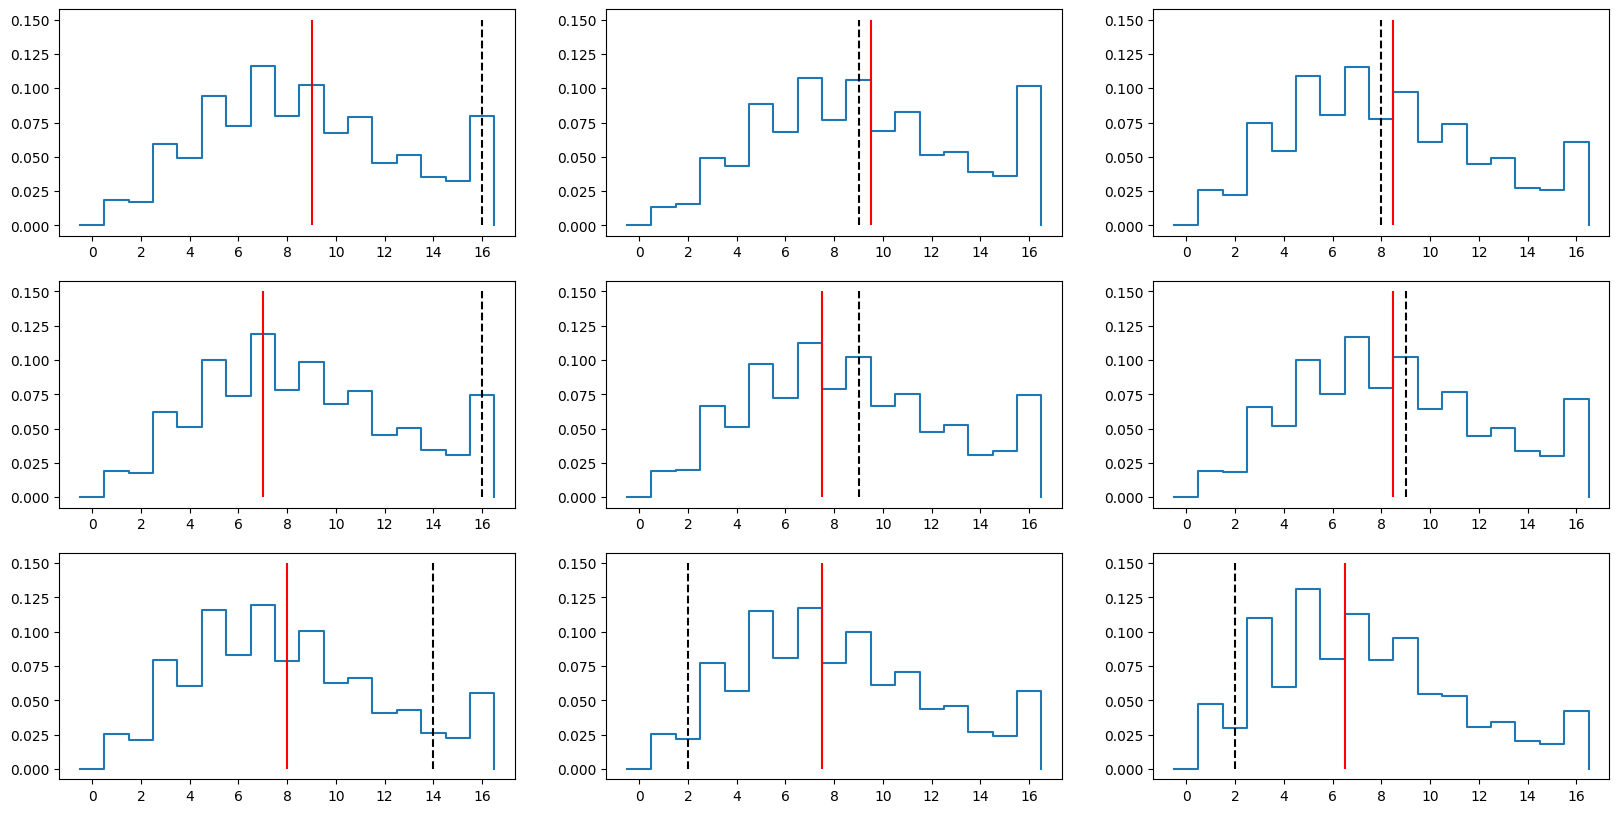

In [50]:
plt.figure(figsize=(20,10))
for i in range(9):
    plt.subplot(3,3,i+1)
    final_test_dists[i].plot_density()
    plt.vlines(run_total_test[i],ymin=0,ymax=.15, color='k', linestyle='--')
    plt.vlines(df_test_game.over_under_line.iloc[i],ymin=0,ymax=.15, color='red')
    plt.xticks(np.linspace(0,16,9))

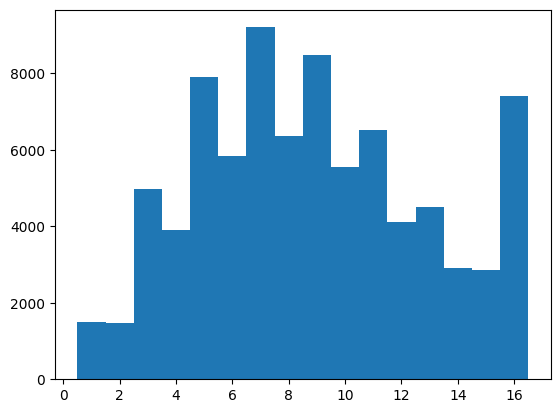

In [51]:
plt.hist(run_total_train, bins=np.linspace(0.5, 16.5, 17));

In [52]:
under_probs_test = np.array([np.sum(final_test_dists.probmat[i,:int(np.ceil(df_test_game.over_under_line.iloc[i]))]) 
                    for i in range(len(run_total_test))])


In [53]:
over_probs_test = np.array([np.sum(final_test_dists[i].probvec[int(np.floor(df_test_game.over_under_line.iloc[i]+1)):]) 
                    for i in range(len(run_total_test))])

In [54]:
push_probs_test = 1-under_probs_test-over_probs_test


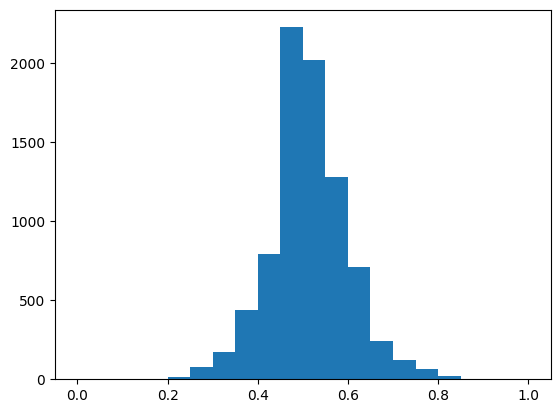

In [55]:
plt.hist(under_probs_test, bins=np.linspace(0,1,21));

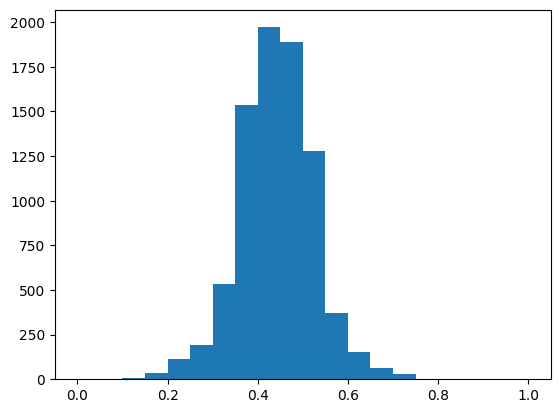

In [56]:
plt.hist(over_probs_test, bins=np.linspace(0,1,21));

#### Examine Calibration of Over/Under Predictions

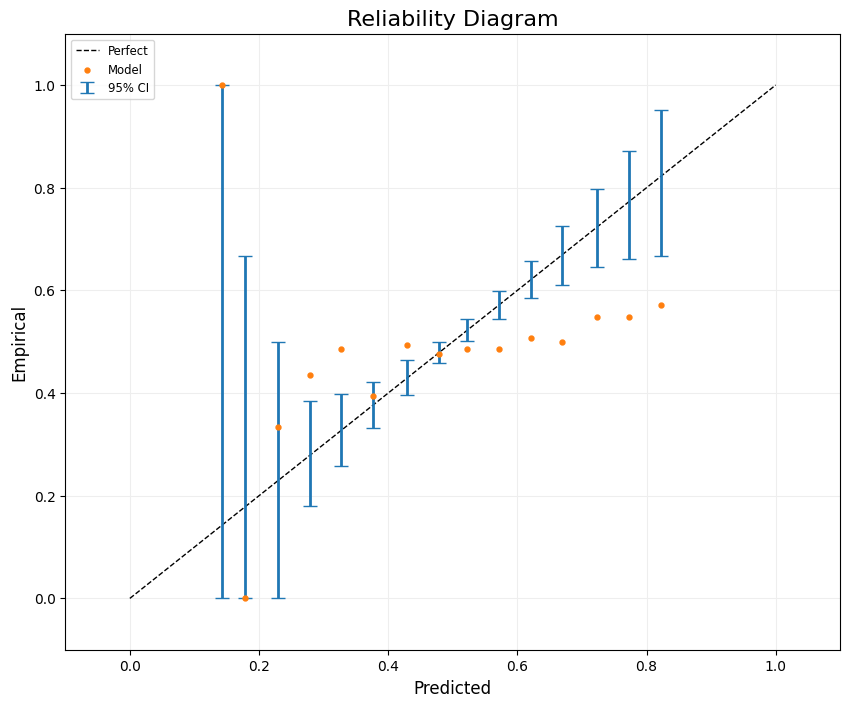

In [57]:
plt.figure(figsize=(10,8))
mli.plot_reliability_diagram((df_test_game.over_under_result=='U').astype(int), under_probs_test, np.linspace(0,1,21));
#plt.ylim([.3,.7])

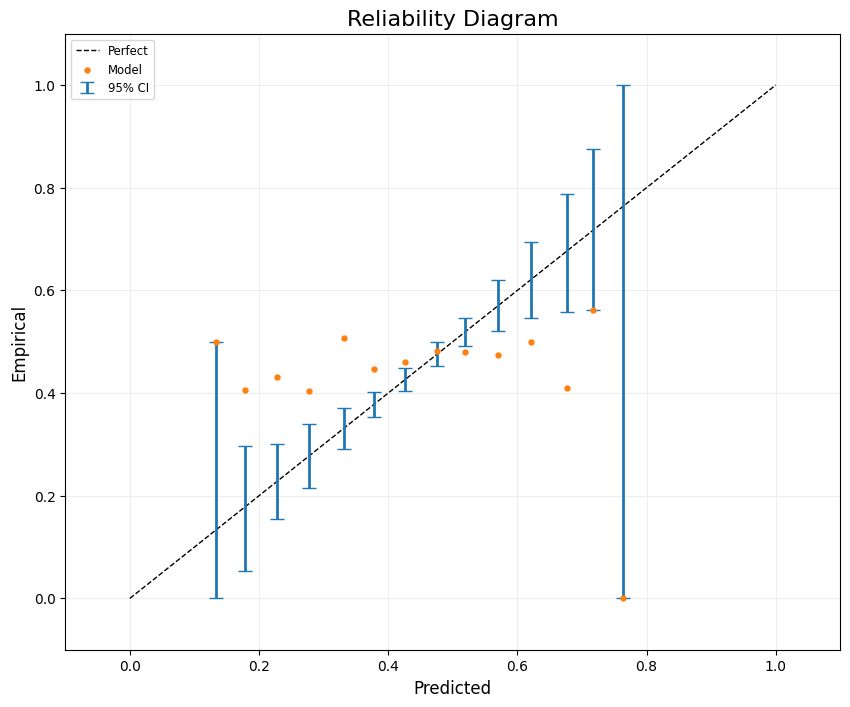

In [58]:
plt.figure(figsize=(10,8))
mli.plot_reliability_diagram((df_test_game.over_under_result=='O').astype(int), over_probs_test, np.linspace(0,1,21));

ValueError: 'yerr' must not contain negative values

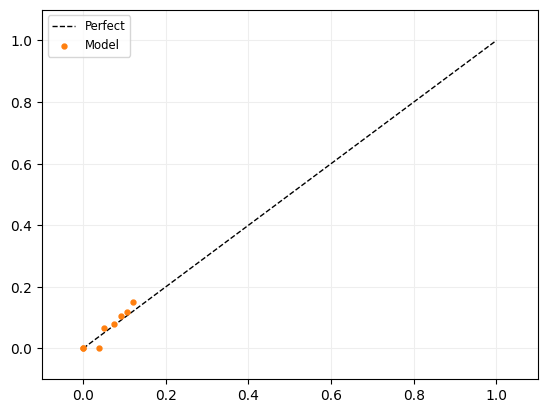

In [59]:
mli.plot_reliability_diagram((df_test_game.over_under_result=='P').astype(int), push_probs_test, np.linspace(0,1,51));
plt.xlim([0,.2])
plt.ylim([0,.2])


In [60]:
def evaluate_edge_probs(oupmat, edge, test_df_w_ouline):
    bet_under = (oupmat[:,1]/(oupmat[:,0] + oupmat[:,1])) > (.5 + edge)
    bet_over = (oupmat[:,0]/(oupmat[:,0] + oupmat[:,1])) > (.5 + edge)
    num_cases_under = np.sum(bet_under)
    num_cases_over = np.sum(bet_over)
    num_cases_total = num_cases_under + num_cases_over
    num_under_correct = (test_df_w_ouline.loc[bet_under,'over_under_result']=='U').sum()
    num_under_push = (test_df_w_ouline.loc[bet_under,'over_under_result']=='P').sum()
    num_over_correct = (test_df_w_ouline.loc[bet_over,'over_under_result']=='O').sum()
    num_over_push = (test_df_w_ouline.loc[bet_over,'over_under_result']=='P').sum()
    num_correct = num_under_correct + num_over_correct
    num_pushes = num_under_push + num_over_push
    num_incorrect = num_cases_total -num_correct - num_pushes
    pct_correct = num_correct / num_cases_total
    pct_pushes = num_pushes / num_cases_total
    pct_incorrect = num_incorrect / num_cases_total
    pct_under_correct = num_under_correct/num_cases_under
    pct_under_push = num_under_push/num_cases_under
    pct_over_correct = num_over_correct/num_cases_over
    pct_over_push = num_over_push/num_cases_over
    print(f'\nThere were {num_cases_total} games that met criteria of edge > {edge} ({num_cases_under} unders and {num_cases_over} overs)')
    print(f'Of them {num_correct} ({np.round(pct_correct,3)}) were correct (winning bets), ({num_under_correct} unders and {num_over_correct} overs) ')
    print(f'and {num_pushes} ({np.round(pct_pushes,3)}) were Pushes ({num_under_push} unders and {num_over_push} overs)')
    print(f'and {num_incorrect} ({np.round(pct_incorrect,3)}) were incorrect (losing bets))')
    winning_edge_m110 = pct_correct*1 + pct_incorrect*(-1.1)
    win_total_m110 = num_correct*1 + num_incorrect*(-1.1)
    print(f'Betting the Under at a line of -110, your profit would have been {np.round(winning_edge_m110,4)} per bet')
    print(f'\t for a total profit of {np.round(win_total_m110,2)} across all {num_cases_total} bets')
    print('\n')
 

In [61]:
oup_probs = np.vstack((over_probs_test, under_probs_test, push_probs_test)).T


In [62]:
for i in np.linspace(.25, .05,5):
    print(f'threshold = {i}')
    evaluate_edge_probs(oup_probs, i, df_test_game)

threshold = 0.25

There were 141 games that met criteria of edge > 0.25 (131 unders and 10 overs)
Of them 77 (0.546) were correct (winning bets), (72 unders and 5 overs) 
and 7 (0.05) were Pushes (5 unders and 2 overs)
and 57 (0.404) were incorrect (losing bets))
Betting the Under at a line of -110, your profit would have been 0.1014 per bet
	 for a total profit of 14.3 across all 141 bets


threshold = 0.2

There were 347 games that met criteria of edge > 0.2 (287 unders and 60 overs)
Of them 189 (0.545) were correct (winning bets), (156 unders and 33 overs) 
and 17 (0.049) were Pushes (12 unders and 5 overs)
and 141 (0.406) were incorrect (losing bets))
Betting the Under at a line of -110, your profit would have been 0.0977 per bet
	 for a total profit of 33.9 across all 347 bets


threshold = 0.15

There were 790 games that met criteria of edge > 0.15 (628 unders and 162 overs)
Of them 400 (0.506) were correct (winning bets), (322 unders and 78 overs) 
and 31 (0.039) were Pushes (24

# Calibration Test

In [63]:
df_test_game.over_under_line.mean()

8.656926274605697

In [64]:
line=8.5

In [66]:
under_probs_test = np.array([np.sum(final_test_dists.probmat[i,:int(np.ceil(line))]) 
                    for i in range(len(run_total_test))])
over_probs_test = np.array([np.sum(final_test_dists[i].probvec[int(np.floor(line))+1:]) 
                    for i in range(len(run_total_test))])
push_probs_test = 1-under_probs_test-over_probs_test

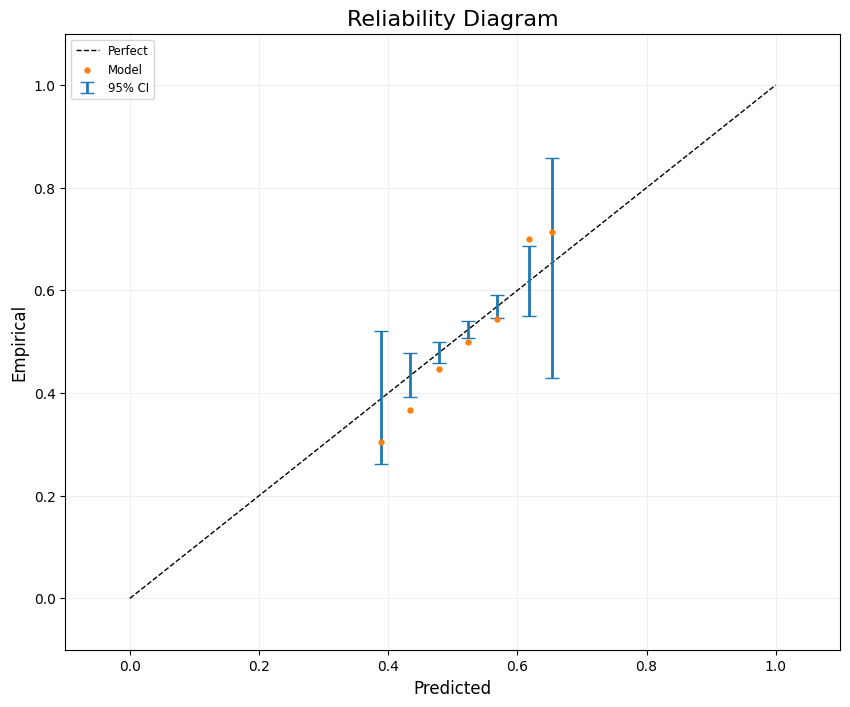

In [67]:
plt.figure(figsize=(10,8))
mli.plot_reliability_diagram((run_total_test<line).astype(int), under_probs_test, np.linspace(0,1,21));

(0.1, 0.9)

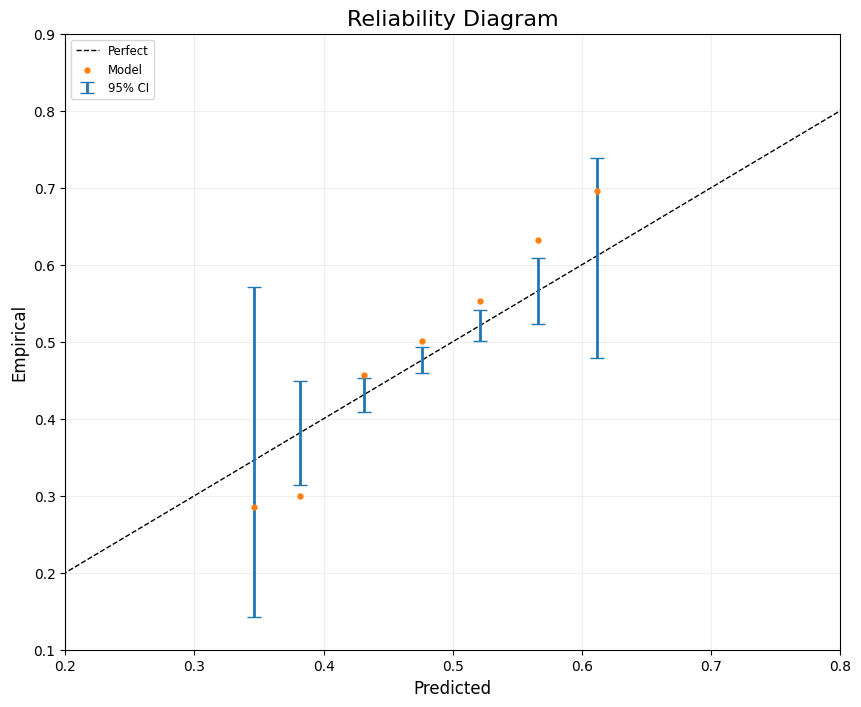

In [68]:
plt.figure(figsize=(10,8))
mli.plot_reliability_diagram((run_total_test>line).astype(int), over_probs_test, np.linspace(0,1,21));
plt.xlim([.2,.8])
plt.ylim([.1,.9])

# Calibration with respect to randomly chosen line

(array([400., 408., 368., 404., 385., 403., 403., 382., 411., 361., 401.,
        402., 388., 385., 393., 402., 386., 411., 365., 353., 368.]),
 array([ 4.75,  5.25,  5.75,  6.25,  6.75,  7.25,  7.75,  8.25,  8.75,
         9.25,  9.75, 10.25, 10.75, 11.25, 11.75, 12.25, 12.75, 13.25,
        13.75, 14.25, 14.75, 15.25]),
 <BarContainer object of 21 artists>)

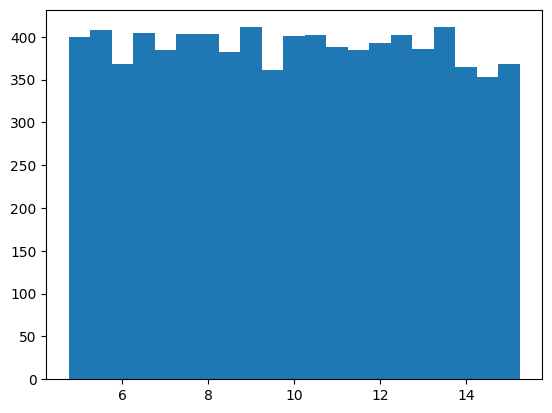

In [69]:
line = np.random.randint(10,31,size=len(run_total_test))/2
plt.hist(line, bins=np.linspace(4.75,15.25,22))

In [70]:
under_probs_test = np.array([np.sum(final_test_dists.probmat[i,:int(np.ceil(line[i]))]) 
                    for i in range(len(run_total_test))])
over_probs_test = np.array([np.sum(final_test_dists[i].probvec[int(np.floor(line[i]))+1:]) 
                    for i in range(len(run_total_test))])
push_probs_test = 1-under_probs_test-over_probs_test

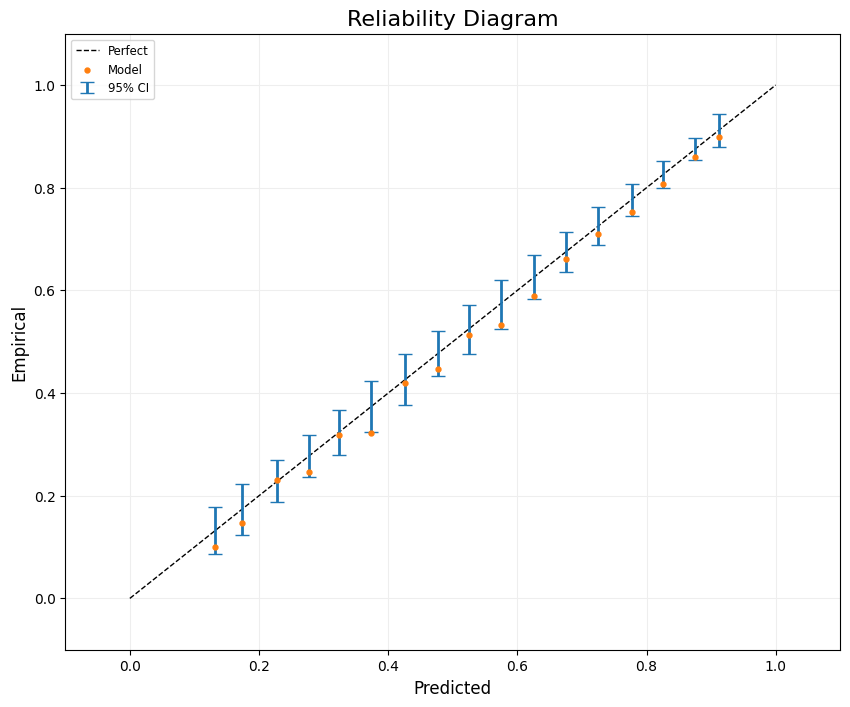

In [71]:
plt.figure(figsize=(10,8))
mli.plot_reliability_diagram((run_total_test<line).astype(int), under_probs_test, np.linspace(0,1,21));

(0.1, 0.9)

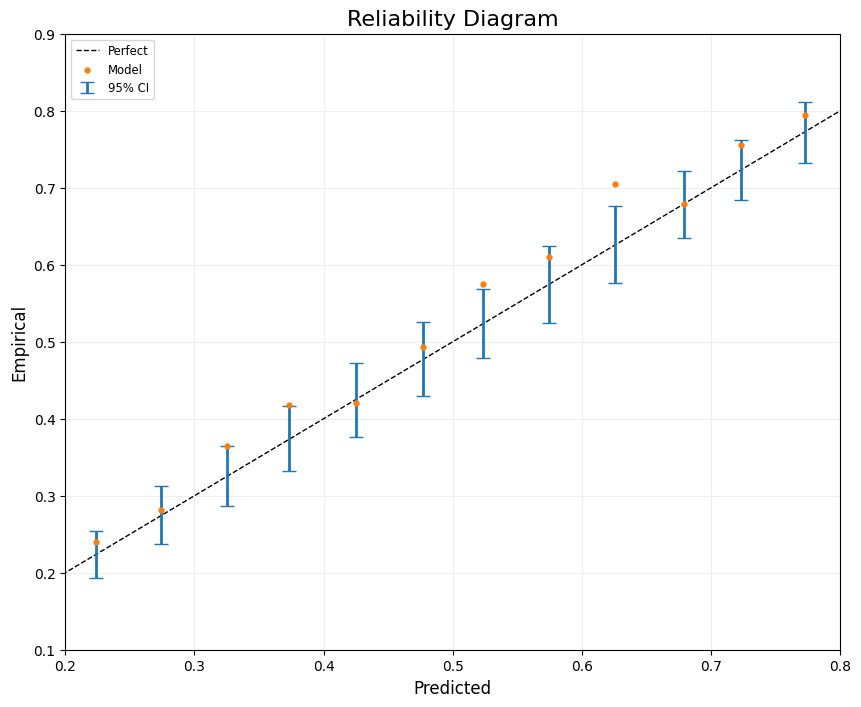

In [72]:
plt.figure(figsize=(10,8))
mli.plot_reliability_diagram((run_total_test>line).astype(int), over_probs_test, np.linspace(0,1,21));
plt.xlim([.2,.8])
plt.ylim([.1,.9])

# Conclusions
- The information inherent in the Vegas line is likely the primary source of the overall miscalibration
- Model tends to over-predict low scores and under-predict high scores.
- This is seen in both the individual team runs scored model and the combined model
- Independence assumption seems less of a problem than before (could do more direct comparison)